## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# (re-)load layers
%run /content/drive/MyDrive/Colab/modules.ipynb
%run /content/drive/MyDrive/Colab/mnist.py

<>:3: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3092293347.py:3: SyntaxWarning: invalid escape sequence '\g'
  Implements linear transform of input y = \gamma * x + \beta


<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

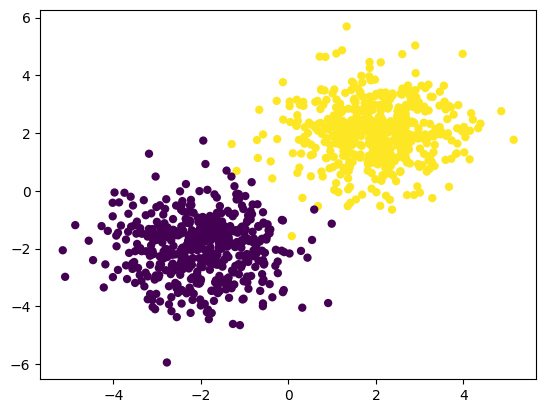

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

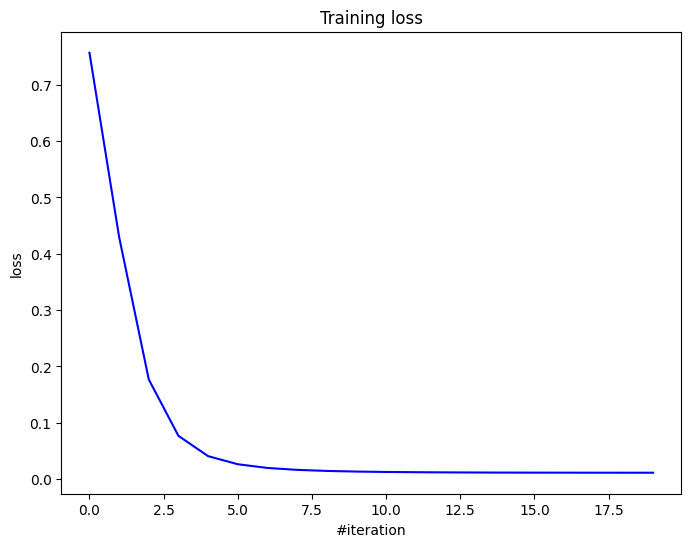

Current loss: 0.011523


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [12]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

HTTPError: HTTP Error 404: Not Found

In [13]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

train_set = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)


test_set = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)

--2025-12-15 12:30:31--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-12-15 12:30:32--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [           <=>      ]  33.20M  16.2MB/s    in 2.0s    

2025-12-15 12:30:34 (16.2 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

One-hot encode the labels first.

In [16]:
# Your code goes here. ################################################

from sklearn.preprocessing import OneHotEncoder

# Готовим MNIST из torchvision datasets и нормализуем его
X_train_full = train_set.data.numpy() / np.float32(256)
y_train_full = train_set.targets.numpy()

X_test = test_set.data.numpy() / np.float32(256)
y_test = test_set.targets.numpy()

# Делим датасет
X_train, X_val = X_train_full[:-10000], X_train_full[-10000:]
y_train, y_val = y_train_full[:-10000], y_train_full[-10000:]

# One-hot
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = encoder.transform(y_val.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Решейпим
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

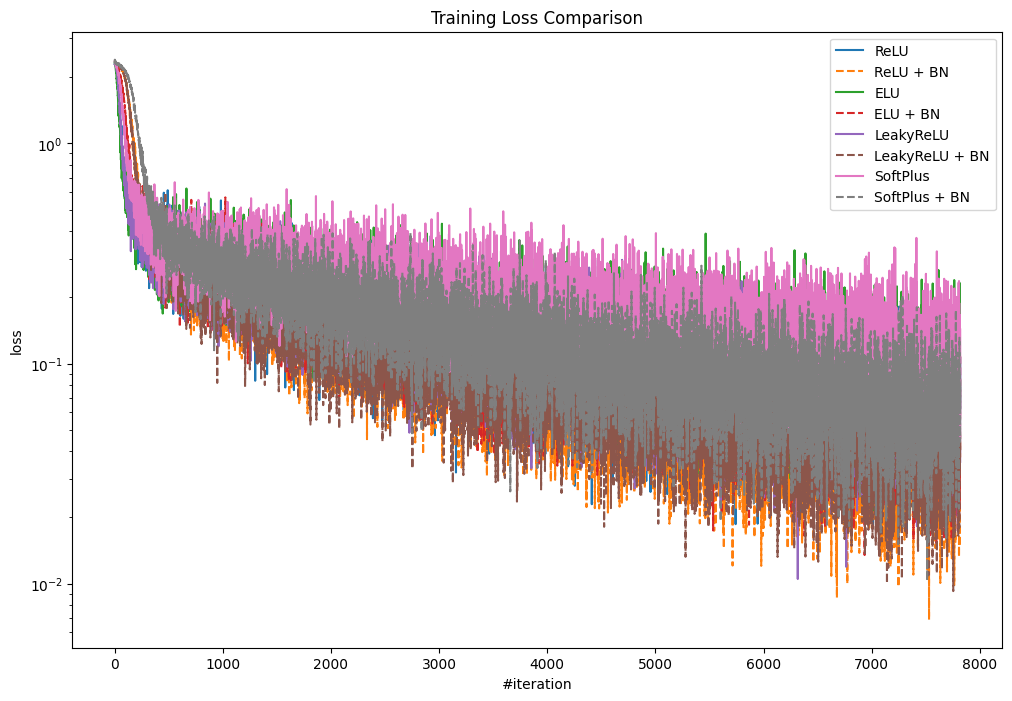

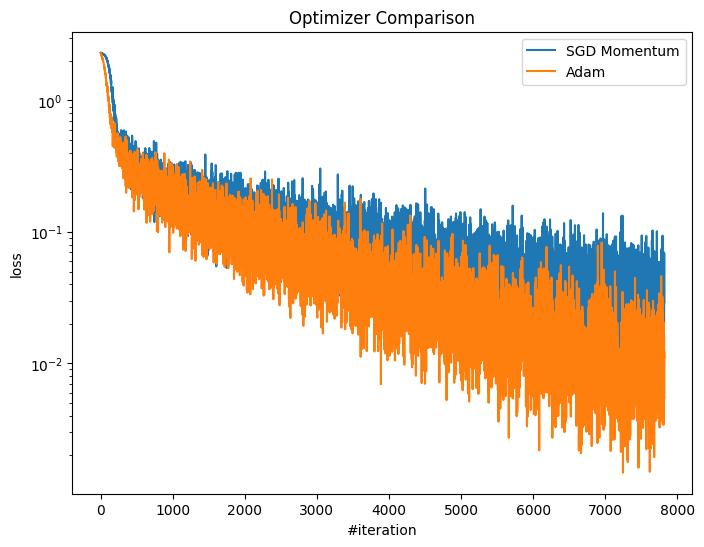

In [18]:
# Your code goes here. ################################################

# Comparison of activation functions and BatchNorm
def build_network(activation, use_batchnorm=False):
    net = Sequential()
    net.add(Linear(784, 128))
    if use_batchnorm:
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(128))
    if activation == 'ReLU':
        net.add(ReLU())
    elif activation == 'ELU':
        net.add(ELU())
    elif activation == 'LeakyReLU':
        net.add(LeakyReLU())
    elif activation == 'SoftPlus':
        net.add(SoftPlus())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

def train_network(net, X_train, y_train_onehot, optimizer_func, optimizer_config, n_epoch=20, batch_size=128):
    loss_history = []
    optimizer_state = {}
    for _ in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train_onehot), batch_size):
            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            optimizer_func(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)
            loss_history.append(loss)
    return loss_history

criterion = ClassNLLCriterion()

activations = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']
loss_histories = {}
loss_histories_bn = {}

for act in activations:
    net = build_network(act)
    loss_histories[act] = train_network(net, X_train, y_train_onehot, sgd_momentum, {'learning_rate': 1e-2, 'momentum': 0.9})

    net_bn = build_network(act, use_batchnorm=True)
    loss_histories_bn[act] = train_network(net_bn, X_train, y_train_onehot, sgd_momentum, {'learning_rate': 1e-2, 'momentum': 0.9})

# Plot losses
plt.figure(figsize=(12, 8))
for act in activations:
    plt.plot(loss_histories[act], label=f'{act}')
    plt.plot(loss_histories_bn[act], label=f'{act} + BN', linestyle='--')
plt.title('Training Loss Comparison')
plt.xlabel('#iteration')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

# Compare SGD Momentum vs Adam
net_sgd = build_network('ReLU', use_batchnorm=True)
loss_sgd = train_network(net_sgd, X_train, y_train_onehot, sgd_momentum, {'learning_rate': 1e-2, 'momentum': 0.9})

net_adam = build_network('ReLU', use_batchnorm=True)
loss_adam = train_network(net_adam, X_train, y_train_onehot, adam_optimizer, {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8})

plt.figure(figsize=(8, 6))
plt.plot(loss_sgd, label='SGD Momentum')
plt.plot(loss_adam, label='Adam')
plt.title('Optimizer Comparison')
plt.xlabel('#iteration')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################

# Different activation functions
# All activations perform reasonably well
# on this network and relatively simple dataset
# ReLU and LeakyReLU can be considered the optimal choice in this setting

# Optimizer performance
# Adam clearly outperforms SGD Momentum
# Though SGD is simpler and cheaper per iteration
# However, Adam converges much faster and requires less iterations
# We might select SGD in the large-scale setups

# Does Batch Normalization Help?
# Yes - from the chart, BN transforms noisy, high-loss curves into smooth,
# low-loss ones across all activations
# Overall, BN provides faster convergence to low loss

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [19]:
# Your code goes here. ################################################

from skimage.transform import rotate
import random

def augment_data(X, y):
    X_aug = []
    y_aug = []
    for x, yy in zip(X, y):
        x_img = x.reshape(28, 28)
        angle = random.uniform(-15, 15)
        x_rot = rotate(x_img, angle, mode='wrap').flatten()
        X_aug.append(x)
        y_aug.append(yy)
        X_aug.append(x_rot)
        y_aug.append(yy)
    return np.array(X_aug), np.array(y_aug)

X_train_aug, y_train_onehot_aug = augment_data(X_train, y_train_onehot)

net = Sequential()
net.add(Linear(784, 256))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(256))
net.add(ReLU())
net.add(Dropout(0.5))
net.add(Linear(256, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Dropout(0.5))
net.add(Linear(128, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate': 1e-2, 'momentum': 0.9}
optimizer_state = {}

n_epoch = 50
batch_size = 128

loss_history = []

for i in range(n_epoch):
    net.train()
    if i % 10 == 0 and i > 0:
        optimizer_config['learning_rate'] *= 0.5  # LR decay
    for x_batch, y_batch in get_batches((X_train_aug, y_train_onehot_aug), batch_size):
        net.zeroGradParameters()
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        sgd_momentum(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)
        loss_history.append(loss)

    # Validation
    net.evaluate()
    val_predictions = net.forward(X_val)
    val_loss = criterion.forward(val_predictions, y_val_onehot)
    print(f'Epoch {i+1}, Val loss: {val_loss}')

Epoch 1, Val loss: 0.198529713121587
Epoch 2, Val loss: 0.156567848020399
Epoch 3, Val loss: 0.14789405573951636
Epoch 4, Val loss: 0.13093048415396702
Epoch 5, Val loss: 0.16968215591439065
Epoch 6, Val loss: 0.1607922429464834
Epoch 7, Val loss: 0.1159654784306229
Epoch 8, Val loss: 0.14391659362900622
Epoch 9, Val loss: 0.10597382881514923
Epoch 10, Val loss: 0.12867442716031896
Epoch 11, Val loss: 0.10060829404392463
Epoch 12, Val loss: 0.12430877338433138
Epoch 13, Val loss: 0.13320906834487845
Epoch 14, Val loss: 0.08026982598367213
Epoch 15, Val loss: 0.09430466618682269
Epoch 16, Val loss: 0.10394570329588382
Epoch 17, Val loss: 0.11075525175831963
Epoch 18, Val loss: 0.1270529138291522
Epoch 19, Val loss: 0.08962721529492201
Epoch 20, Val loss: 0.09777512194166053
Epoch 21, Val loss: 0.10904596432420657
Epoch 22, Val loss: 0.08932196430614235
Epoch 23, Val loss: 0.07130694320879573
Epoch 24, Val loss: 0.08552248541007455
Epoch 25, Val loss: 0.08854631164383966
Epoch 26, Val lo

Print here your accuracy on test set. It should be around 90%.

In [20]:
# Your answer goes here. ################################################

# Test accuracy
net.evaluate()
test_predictions = np.argmax(net.forward(X_test), axis=1)
test_accuracy = np.mean(test_predictions == y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Test accuracy: 97.58%


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [21]:
# Your beautiful code here.

# PyTorch implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class PyTorchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.logsoftmax(x)
        return x

# Data loaders
train_dataset = TensorDataset(torch.tensor(X_train_aug, dtype=torch.float32), torch.tensor(np.argmax(y_train_onehot_aug, axis=1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=128)

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=128)

model = PyTorchNet()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(50):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch)
            val_loss += criterion(outputs, y_batch).item()
    print(f'Epoch {epoch+1}, Val loss: {val_loss / len(val_loader)}')

# Test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
print(f'PyTorch Test accuracy: {100 * correct / total:.2f}%')

Epoch 1, Val loss: 0.13804156227108044
Epoch 2, Val loss: 0.10593100712056967
Epoch 3, Val loss: 0.0896656305552755
Epoch 4, Val loss: 0.08428806350330668
Epoch 5, Val loss: 0.07945472201261716
Epoch 6, Val loss: 0.07139517322383067
Epoch 7, Val loss: 0.07108515952979037
Epoch 8, Val loss: 0.06719920077343483
Epoch 9, Val loss: 0.06476925323345946
Epoch 10, Val loss: 0.06467146727350788
Epoch 11, Val loss: 0.0615201736726692
Epoch 12, Val loss: 0.0638544303004017
Epoch 13, Val loss: 0.060282613171406
Epoch 14, Val loss: 0.05839956869795636
Epoch 15, Val loss: 0.05970813596364747
Epoch 16, Val loss: 0.05882634668643409
Epoch 17, Val loss: 0.057744475057248404
Epoch 18, Val loss: 0.05955241561006708
Epoch 19, Val loss: 0.05731998143431766
Epoch 20, Val loss: 0.05572366410029368
Epoch 21, Val loss: 0.059554170280373714
Epoch 22, Val loss: 0.05512455767617396
Epoch 23, Val loss: 0.05760831529491204
Epoch 24, Val loss: 0.05798721338270079
Epoch 25, Val loss: 0.055052688739504196
Epoch 26, V